In [1]:
import torch
import pandas as pd
from pandas import DataFrame
import os
import numpy as np
import albumentations as A
import cv2
import math
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import json
import multiprocessing
from tqdm import tqdm
import _thread
import time
import threading


In [2]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

setup_seed(2022)

In [3]:
df = pd.read_csv("data/图片虫子位置详情表.csv", encoding="gbk")
df


,序号,文件名,虫子编号,虫子名称,中心点x坐标,中心点y坐标,左上角x坐标,左上角y坐标,右下角x坐标,右下角y坐标
0,1,00001.jpg,0,无,NaN,NaN,NaN,NaN,NaN,NaN
1,2,00004.jpg,0,无,NaN,NaN,NaN,NaN,NaN,NaN
2,3,00006.jpg,0,无,NaN,NaN,NaN,NaN,NaN,NaN
3,4,00008.jpg,7,二化螟,1984.0,2150.0,1835.0,1920.0,2134.0,2380.0
4,5,00008.jpg,228,二点委夜蛾,3301.0,827.0,3040.0,618.0,3563.0,1037.0
...,...,...,...,...,...,...,...,...,...,...
2651,2652,03811.jpg,0,无,NaN,NaN,NaN,NaN,NaN,NaN
2652,2653,03812.jpg,430,豆野螟,1441.0,2270.0,1178.0,2130.0,1703.0,2411.0
2653,2654,03813.jpg,10,褐飞虱属,2310.0,623.0,2277.0,566.0,2343.0,680.0
2654,2655,03813.jpg,280,黄毒蛾,3070.0,217.0,2878.0,70.0,3262.0,365.0


In [4]:
df1 = pd.read_csv("data/无位置信息的图片汇总表.csv", encoding="gbk")
df1


,序号,文件名
0,1,00002.jpg
1,2,00003.jpg
2,3,00005.jpg
3,4,00007.jpg
4,5,00010.jpg
...,...,...
797,798,03794.jpg
798,799,03800.jpg
799,800,03804.jpg
800,801,03814.jpg


In [5]:
def cmp(x):
    return x[0]


dir_label = OrderedDict()
list_label = []
label = []
for label_id, label_name in zip(df["虫子编号"], df["虫子名称"]):
    label.append((label_id, label_name))
label = list(set(label))
label.sort(key=cmp)
del label[0]
for i, t in enumerate(label):
    dir_label[t[1]] = i
    list_label.append(t[1])
json_label = json.dumps(dir_label, indent=4 ,ensure_ascii=False)
with open("data/label.json", "w+") as f:
    f.write(json_label)
dir_label


OrderedDict([('大螟', 0),
             ('二化螟', 1),
             ('稻纵卷叶螟', 2),
             ('白背飞虱', 3),
             ('褐飞虱属', 4),
             ('地老虎', 5),
             ('蝼蛄', 6),
             ('粘虫', 7),
             ('草地螟', 8),
             ('甜菜夜蛾', 9),
             ('黄足猎蝽', 10),
             ('八点灰灯蛾', 11),
             ('棉铃虫', 12),
             ('二点委夜蛾', 13),
             ('甘蓝夜蛾', 14),
             ('蟋蟀', 15),
             ('黄毒蛾', 16),
             ('稻螟蛉', 17),
             ('紫条尺蛾', 18),
             ('水螟蛾', 19),
             ('线委夜蛾', 20),
             ('甜菜白带野螟', 21),
             ('歧角螟', 22),
             ('瓜绢野螟', 23),
             ('豆野螟', 24),
             ('石蛾', 25),
             ('大黑鳃金龟', 26),
             ('干纹冬夜蛾', 27)])

In [6]:
random.seed(2022)
dir = OrderedDict()
dir_train = OrderedDict()
dir_valid = OrderedDict()
for path in list(
    set([os.path.join("data/image", path).replace("\\", "/") for path in df["文件名"]])
):
    dir[path] = []
for path, label_name, x_left, y_left, x_right, y_right in zip(
    df["文件名"],
    df["虫子名称"],
    df["左上角x坐标"],
    df["左上角y坐标"],
    df["右下角x坐标"],
    df["右下角y坐标"],
):
    path = os.path.join("data/image", path).replace("\\", "/")
    # w = x_right - x_left
    # h = y_right - y_left
    try:
        dir[path].append([dir_label[label_name], x_left, y_left, x_right, y_right])
    except:
        continue
dir_train_name = random.sample(dir.keys(), int(0.9 * len(dir)))
for name in dir.keys():
    if name in dir_train_name:
        dir_train[name] = dir[name]
    else:
        dir_valid[name] = dir[name]
json_train = json.dumps(dir_train, indent=4)
json_valid = json.dumps(dir_valid, indent=4)
with open("data/train.json", "w+") as f:
    f.write(json_train)
with open("data/valid.json", "w+") as f:
    f.write(json_valid)
print(len(dir), len(dir_train), len(dir_valid))


2213 1991 222


In [7]:
def IoU(box1, box2):
    # 计算中间矩形的宽高
    in_h = min(box1[2], box2[2]) - max(box1[0], box2[0])
    in_w = min(box1[3], box2[3]) - max(box1[1], box2[1])

    # 计算交集、并集面积
    inter = 0 if in_h < 0 or in_w < 0 else in_h * in_w
    union = (
        (box1[2] - box1[0]) * (box1[3] - box1[1])
        + (box2[2] - box2[0]) * (box2[3] - box2[1])
        - inter
    )
    # 计算IoU
    iou = inter / union
    return iou


In [8]:
num = 0
dir_expand_train = OrderedDict()


def cut_train(image_path, save_dir, boxes, shape):
    global num
    img = cv2.imread(image_path)
    # print(image_path)
    h, w = img.shape[:2]
    for box in boxes:
        center_x, center_y = int(box[1] + (box[3] - box[1]) / 2), int(
            (box[4] - box[2]) / 2 + box[2]
        )
        x, y, r, b = (
            center_x - shape // 2,
            center_y - shape // 2,
            center_x + shape // 2,
            center_y + shape // 2,
        )
        x = max(0, x)
        y = max(0, y)
        r = min(r, w)
        b = min(b, h)
        # print(x, y, r, b)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        num += 1
        path = os.path.join(save_dir, str(num) + ".png").replace("\\", "/")
        annotations = []
        cv2.imwrite(path, img[y:b, x:r], [int(cv2.IMWRITE_JPEG_QUALITY), 100])
        for e_box in boxes:
            if (
                not (e_box[1] >= r or e_box[3] <= x or e_box[2] >= b or e_box[4] <= y)
            ) and IoU(
                [
                    max(x, e_box[1]),
                    max(y, e_box[2]),
                    min(r, e_box[3]),
                    min(b, e_box[4]),
                ],
                e_box[1:5],
            ) >= 0.3:
                e_box = [int(i) for i in e_box]
                # print(e_box[1:5])
                e_box[1] = max(0, e_box[1] - x)
                e_box[2] = max(0, e_box[2] - y)
                e_box[3] = min(r, e_box[3] - x)
                e_box[4] = min(b, e_box[4] - y)
                annotations.append(e_box)
        dir_expand_train[path] = annotations
        #         a = cv2.rectangle(img[y:b,x:r],(e_box[1],e_box[2]),(e_box[3],e_box[4]), color=(255, 0, 0), thickness=2)
        # plt.imshow(a)
        # plt.show()
        # print(annotations)


for path in tqdm(dir_train.keys(), total=len(dir_train)):
    # t_thread = threading.Thread(target=cut_train ,args=(path, "mydataset/images/expand_train", dir_train[path], 1024))
    # t_thread.start() 
    cut_train(path, "mydataset/images/expand_train", dir_train[path], 1024) 
    # cut(path, "data/expand_image", dir_train[path], 1024)


json_expend_train = json.dumps(dir_expand_train.copy(), indent=4)
with open("mydataset/expand_train.json", "w+") as f:
    f.write(json_expend_train)


100%|██████████| 1991/1991 [05:40<00:00,  5.85it/s]


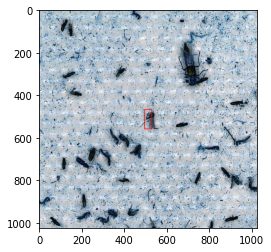

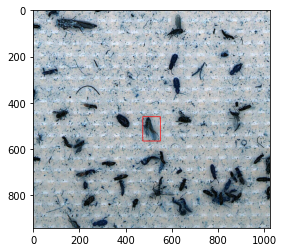

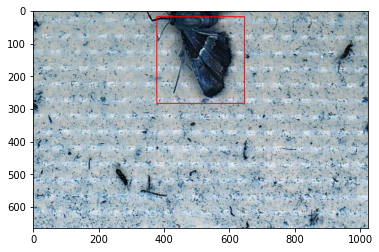

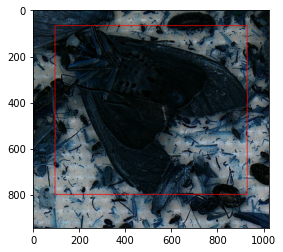

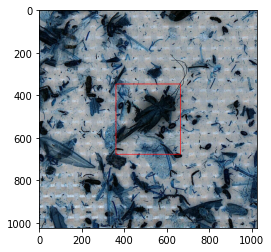

In [9]:
for i, (path, boxes) in enumerate(dir_expand_train.copy().items()):
    if i >= 5:
        continue
    img = cv2.imread(path)
    for box in boxes:
        a = cv2.rectangle(
            img, (box[1], box[2]), (box[3], box[4]), color=(255, 0, 0), thickness=2
        )
    plt.imshow(a)
    plt.show()


In [14]:
num = 0
dir_expand_valid = OrderedDict()


def cut_valid(image_path, save_dir, boxes, window_shape, step):
    global num
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    window_left, window_right = (0, 0), (window_shape, window_shape)
    if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    for i in range(0, w, step):
        for j in range(0, h, step):
            if random.random() > 0.1:
                continue
            window_left = (i, j)     
            window_right = (min(i + window_shape, w), min(j + window_shape, h))
            num += 1
            path = os.path.join(save_dir, str(num) + ".png").replace("\\", "/")
            x, y = window_left
            r, b = window_right
            cv2.imwrite(
                path,
                img[y:b, x:r],
                [int(cv2.IMWRITE_JPEG_QUALITY), 100],
            )
            annotations = []
            for e_box in boxes:
                if (
                    not (e_box[1] >= r or e_box[3] <= x or e_box[2] >= b or e_box[4] <= y)
                ) and IoU(
                    [
                        max(x, e_box[1]),
                        max(y, e_box[2]),
                        min(r, e_box[3]),
                        min(b, e_box[4]),
                    ],
                    e_box[1:5],
                ) >= 0.3:
                    e_box = [int(i) for i in e_box]
                    # print(e_box[1:5])
                    e_box[1] = max(0, e_box[1] - x)
                    e_box[2] = max(0, e_box[2] - y)
                    e_box[3] = min(r, e_box[3] - x)
                    e_box[4] = min(b, e_box[4] - y)
                    annotations.append(e_box)
            dir_expand_valid[path] = annotations     


for path in tqdm(dir_valid.keys(), total=len(dir_valid)):
    # t_thread = threading.Thread(target=cut_valid ,args=(path, "mydataset/images/expand_valid", dir_valid[path], 1024, 512))
    # t_thread.start()  
    cut_valid(path, "mydataset/images/expand_valid", dir_valid[path], 1024, 512)


json_expend_valid = json.dumps(dir_expand_valid.copy(), indent=4)
with open("mydataset/expand_valid.json", "w+") as f:
    f.write(json_expend_valid)                      
# cut_valid("data/image/01992.jpg", "data/expand_valid_image", dir_valid["data/image/01992.jpg"], 1024, 512)

100%|██████████| 222/222 [01:29<00:00,  2.49it/s]


mydataset/images/expand_valid/88.png


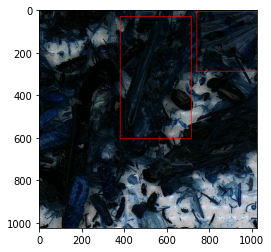

mydataset/images/expand_valid/90.png


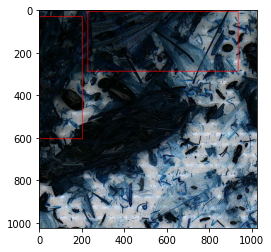

mydataset/images/expand_valid/258.png


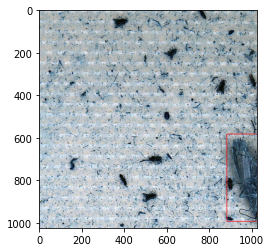

mydataset/images/expand_valid/488.png


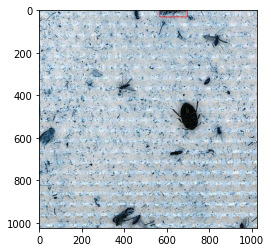

mydataset/images/expand_valid/489.png


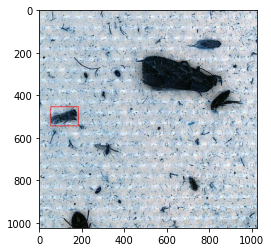

mydataset/images/expand_valid/492.png


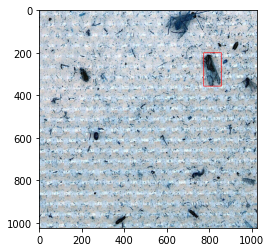

In [15]:
for i, (path, boxes) in enumerate(dir_expand_valid.copy().items()):
    if i>= 500 or not len(boxes):
        continue
    img = cv2.imread(path)
    for box in boxes:
        a = cv2.rectangle(
            img, (box[1], box[2]), (box[3], box[4]), color=(255, 0, 0), thickness=2
        )
    print(path)
    plt.imshow(a)
    plt.show()
